In [1]:
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Potato Disease Classification/Data', 
    shuffle=True, 
    image_size=(IMAGE_SIZE, IMAGE_SIZE), 
    batch_size=BATCH_SIZE
)

Found 2171 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[0 1 1 1 0 2 0 1 0 0 0 0 1 0 0 1 1 1 2 0 0 1 0 1 1 0 1 0 0 0 1 1]


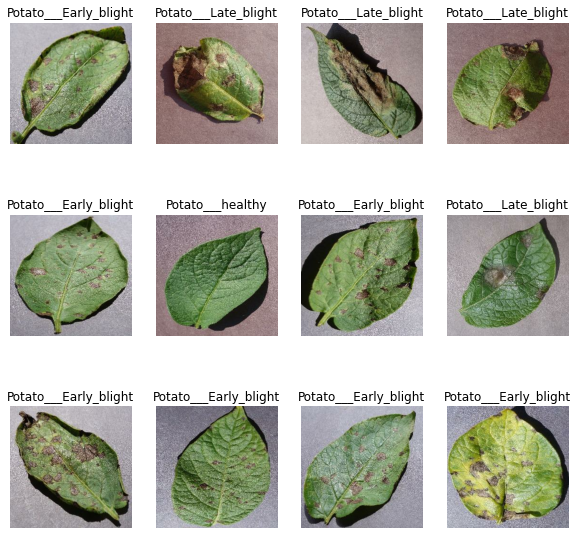

In [ ]:
plt.figure(figsize=(10, 10))
for img_batch, labels_batch in dataset.take(1):
    print(img_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

In [ ]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=15)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
for img_batch, labels_batch in dataset.take(1):
    print(img_batch[0].numpy() / 255)

[[[0.5921569  0.50980395 0.5058824 ]
  [0.5568628  0.4745098  0.47058824]
  [0.5568628  0.4745098  0.47058824]
  ...
  [0.58431375 0.5058824  0.5411765 ]
  [0.61960787 0.5411765  0.5764706 ]
  [0.64705884 0.5686275  0.6039216 ]]

 [[0.5647059  0.48235294 0.47843137]
  [0.54509807 0.4627451  0.45882353]
  [0.56078434 0.47843137 0.4745098 ]
  ...
  [0.57254905 0.49411765 0.5294118 ]
  [0.59607846 0.5176471  0.5529412 ]
  [0.6156863  0.5372549  0.57254905]]

 [[0.5529412  0.47058824 0.46666667]
  [0.5529412  0.47058824 0.46666667]
  [0.5803922  0.49803922 0.49411765]
  ...
  [0.6117647  0.53333336 0.5686275 ]
  [0.62352943 0.54509807 0.5803922 ]
  [0.6313726  0.5529412  0.5882353 ]]

 ...

 [[0.50980395 0.4117647  0.42352942]
  [0.5176471  0.41960785 0.43137255]
  [0.5529412  0.45490196 0.46666667]
  ...
  [0.56078434 0.47843137 0.5058824 ]
  [0.654902   0.57254905 0.6       ]
  [0.5568628  0.4745098  0.5019608 ]]

 [[0.5372549  0.4392157  0.4509804 ]
  [0.5372549  0.4392157  0.4509804 ]


In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, batch_size=BATCH_SIZE, validation_data=val_ds, verbose=1, epochs=EPOCHS)

Epoch 1/50
54/54 [==============================] - 251s 242ms/step - loss: 0.9186 - accuracy: 0.4881 - val_loss: 0.8430 - val_accuracy: 0.5312
Epoch 2/50
54/54 [==============================] - 6s 120ms/step - loss: 0.6766 - accuracy: 0.6831 - val_loss: 0.4906 - val_accuracy: 0.7760
Epoch 3/50
54/54 [==============================] - 6s 119ms/step - loss: 0.5229 - accuracy: 0.7632 - val_loss: 0.5867 - val_accuracy: 0.7135
Epoch 4/50
54/54 [==============================] - 6s 118ms/step - loss: 0.3901 - accuracy: 0.8328 - val_loss: 0.3452 - val_accuracy: 0.8490
Epoch 5/50
54/54 [==============================] - 6s 119ms/step - loss: 0.3119 - accuracy: 0.8717 - val_loss: 0.1984 - val_accuracy: 0.9375
Epoch 6/50
54/54 [==============================] - 6s 119ms/step - loss: 0.2591 - accuracy: 0.8979 - val_loss: 0.1574 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 6s 119ms/step - loss: 0.2951 - accuracy: 0.8880 - val_loss: 0.1489 - val_accuracy: 0.9323
Epoc

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 49ms/step - loss: 0.0736 - accuracy: 0.9805


In [ ]:
scores

[0.07356773316860199, 0.98046875]

In [ ]:
history.params

{'epochs': 50, 'steps': 54, 'verbose': 1}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Loss')

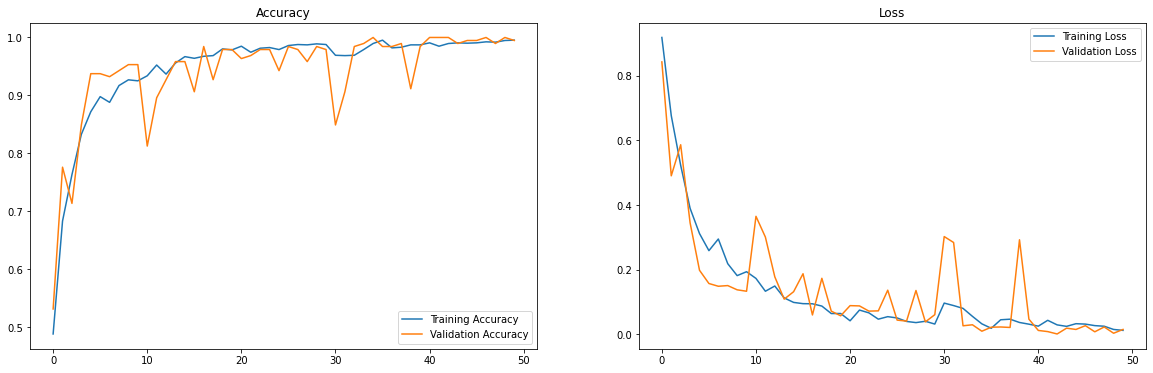

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')

In [ ]:
import numpy as np

Prediction: Potato___Late_blight


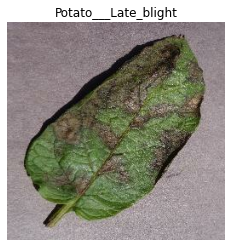

In [ ]:
for img_batch, labels_batch in test_ds.take(1):
  image = img_batch[0].numpy().astype('uint8')
  plt.imshow(image)
  plt.title(class_names[labels_batch[0]])
  plt.axis('off')

  batch_prediction = model.predict(img_batch)
  print("Prediction:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)

  return predicted_class, confidence

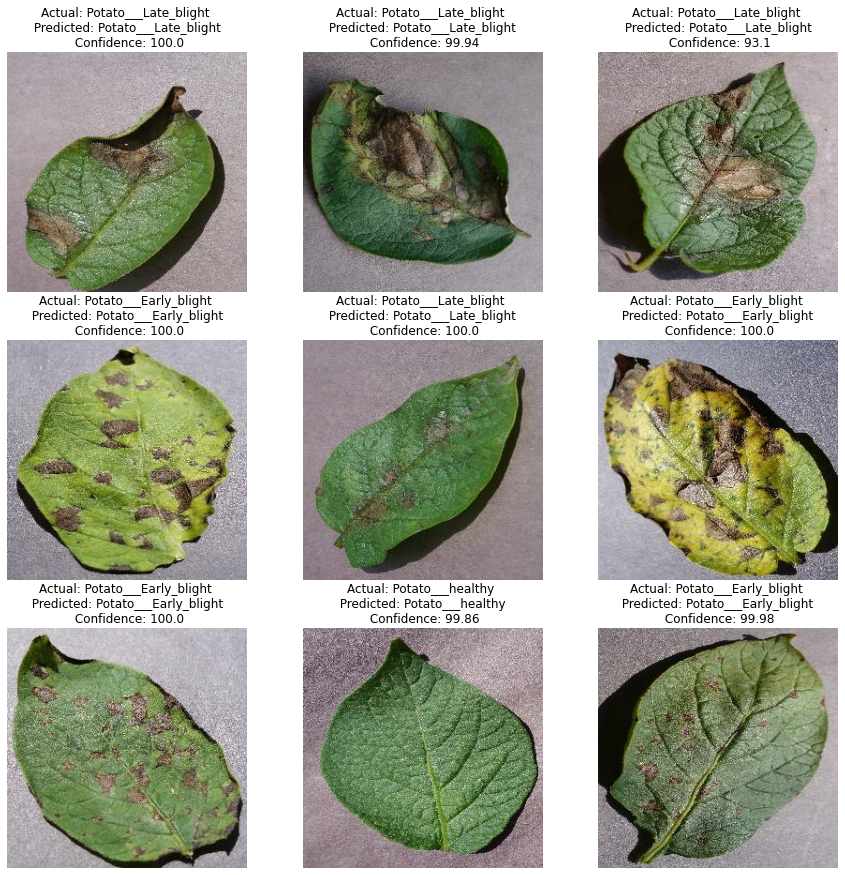

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f'Actual: {actual_class} \n Predicted: {predicted_class} \n Confidence: {confidence}')
    plt.axis('off')

In [ ]:
model_version = max([int(i) for i in (os.listdir('/content/drive/MyDrive/Potato Disease Classification/Models') + [0])]) + 1

In [ ]:
model.save(f'/content/drive/MyDrive/Potato Disease Classification/Models/{model_version}')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Potato Disease Classification/Models/3/assets
